<a href="https://colab.research.google.com/github/lsh3163/MachineLearning_Study/blob/master/CycleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Image to Image Translation with CycleGAN

In [1]:
!git clone https://github.com/pkmital/CycleGAN.git

Cloning into 'CycleGAN'...
remote: Enumerating objects: 48, done.
remote: Total 48 (delta 0), reused 0 (delta 0), pack-reused 48
Unpacking objects: 100% (48/48), done.


## Introduction
* we will make cat-> dog

## Encoder

In [2]:
!pip install cadl
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as tfl
from cadl.cycle_gan import lrelu, instance_norm

    100% |████████████████████████████████| 153kB 12.4MB/s 
    100% |████████████████████████████████| 1.1MB 18.8MB/s 
    100% |████████████████████████████████| 1.6MB 15.7MB/s 
    100% |████████████████████████████████| 92kB 24.7MB/s 
    100% |████████████████████████████████| 686kB 23.6MB/s 
    100% |████████████████████████████████| 16.1MB 3.1MB/s 
    100% |████████████████████████████████| 71kB 21.6MB/s 
    100% |████████████████████████████████| 5.6MB 7.6MB/s 
    100% |████████████████████████████████| 204kB 25.4MB/s 
    100% |████████████████████████████████| 327kB 24.8MB/s 
    100% |████████████████████████████████| 3.2MB 3.9MB/s 
    100% |████████████████████████████████| 16.1MB 2.9MB/s 
  Running setup.py bdist_wheel for bs4 ... - done
  Stored in directory: /root/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac6

/usr/local/lib/python3.6/dist-packages/cadl/cycle_gan.py:21: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "<decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 87, in catch_config_error
    re

In [0]:
def encoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'encoder', reuse=reuse):
        h = tf.pad(x, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=7,
                stride=1,
                padding='VALID',
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='3',
                reuse=reuse)
    return h

## Residual Blocks and Transformer

In [0]:
def residual_block(x, n_channels=128, normalizer_fn=instance_norm,
        activation_fn=lrelu, kernel_size=3, scope=None, reuse=None):
    with tf.variable_scope(scope or 'residual', reuse=reuse):
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_channels,
                kernel_size=kernel_size,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                padding='VALID',
                activation_fn=None,
                scope='2',
                reuse=reuse)
        h = tf.add(x, h)
    return h

In [0]:
def transform(x, img_size=256, reuse=None):
    h = x
    if img_size >= 256:
        n_blocks = 9
    else:
        n_blocks = 6
    for block_i in range(n_blocks):
        with tf.variable_scope('block_{}'.format(block_i), reuse=reuse):
            h = residual_block(h, reuse=reuse)
    return h

## Decoder

In [0]:
def decoder(x, n_filters=32, k_size=3, normalizer_fn=instance_norm,
        activation_fn=lrelu, scope=None, reuse=None):
    with tf.variable_scope(scope or 'decoder', reuse=reuse):
        h = tfl.conv2d_transpose(
                inputs=x,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d_transpose(
                inputs=h,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                normalizer_fn=normalizer_fn,
                activation_fn=activation_fn,
                scope='2',
                reuse=reuse)
        h = tf.pad(h, [[0, 0], [k_size, k_size], [k_size, k_size], [0, 0]],
                "REFLECT")
        h = tfl.conv2d(
                inputs=h,
                num_outputs=3,
                kernel_size=7,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                padding='VALID',
                normalizer_fn=normalizer_fn,
                activation_fn=tf.nn.tanh,
                scope='3',
                reuse=reuse)
    return h

In [0]:
def generator(x, scope=None, reuse=None):
    img_size = x.get_shape().as_list()[1]
    with tf.variable_scope(scope or 'generator', reuse=reuse):
        h = encoder(x, reuse=reuse)
        h = transform(h, img_size, reuse=reuse)
        h = decoder(h, reuse=reuse)
    return h

## PatchGAN, Receptive Field Sizes, and the Discriminator

In [0]:
def discriminator(x, n_filters=64, k_size=4, activation_fn=lrelu,
        normalizer_fn=instance_norm, scope=None, reuse=None):
    with tf.variable_scope(scope or 'discriminator', reuse=reuse):
        h = tfl.conv2d(
                inputs=x,
                num_outputs=n_filters,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=None,
                scope='1',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 2,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='2',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 4,
                kernel_size=k_size,
                stride=2,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='3',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=n_filters * 8,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=activation_fn,
                normalizer_fn=normalizer_fn,
                scope='4',
                reuse=reuse)
        h = tfl.conv2d(
                inputs=h,
                num_outputs=1,
                kernel_size=k_size,
                stride=1,
                weights_initializer=tf.truncated_normal_initializer(stddev=0.02),
                biases_initializer=None,
                activation_fn=tf.nn.sigmoid,
                scope='5',
                reuse=reuse)
        return h

## Connecting the Pieces

In [0]:
img_size = 256
X_real = tf.placeholder(name='X', shape=[1, img_size, img_size, 3], dtype=tf.float32)
Y_real = tf.placeholder(name='Y', shape=[1, img_size, img_size, 3], dtype=tf.float32)

In [0]:
X_fake = generator(Y_real, scope='G_yx')
Y_fake = generator(X_real, scope='G_xy')

In [0]:
X_cycle = generator(Y_fake, scope='G_yx', reuse=True)
Y_cycle = generator(X_fake, scope='G_xy', reuse=True)

In [0]:
D_X_real = discriminator(X_real, scope='D_X')
D_Y_real = discriminator(Y_real, scope='D_Y')
D_X_fake = discriminator(X_fake, scope='D_X', reuse=True)
D_Y_fake = discriminator(Y_fake, scope='D_Y', reuse=True)

In [0]:
l1 = 10.0
loss_cycle = tf.reduce_mean(l1 * tf.abs(X_real - X_cycle)) + \
             tf.reduce_mean(l1 * tf.abs(Y_real - Y_cycle))
loss_G_xy = tf.reduce_mean(tf.square(D_Y_fake - 1.0)) + loss_cycle
loss_G_yx = tf.reduce_mean(tf.square(D_X_fake - 1.0)) + loss_cycle

In [0]:
X_fake_sample = tf.placeholder(name='X_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)
Y_fake_sample = tf.placeholder(name='Y_fake_sample',
        shape=[None, img_size, img_size, 3], dtype=tf.float32)

In [0]:
D_X_fake_sample = discriminator(X_fake_sample, scope='D_X', reuse=True)
D_Y_fake_sample = discriminator(Y_fake_sample, scope='D_Y', reuse=True)

In [0]:
loss_D_Y = (tf.reduce_mean(tf.square(D_Y_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_Y_fake_sample))) / 2.0
loss_D_X = (tf.reduce_mean(tf.square(D_X_real - 1.0)) + \
            tf.reduce_mean(tf.square(D_X_fake_sample))) / 2.0

## Optimizer

In [0]:
tf.reset_default_graph()
from cadl.cycle_gan import cycle_gan
net = cycle_gan(img_size=img_size)

In [18]:
list(net.items())

[('G_vars',
  [<tf.Variable 'G_xy/encoder/1/Conv/weights:0' shape=(7, 7, 3, 32) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/scale:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/1/instance_norm/offset:0' shape=(32,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/Conv/weights:0' shape=(3, 3, 32, 64) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/scale:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/2/instance_norm/offset:0' shape=(64,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/Conv/weights:0' shape=(3, 3, 64, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/scale:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/encoder/3/instance_norm/offset:0' shape=(128,) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/Conv/weights:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
   <tf.Variable 'G_xy/block_0/residual/1/instance_norm/scale:0' shape=(128,) dtype=float32_ref

In [0]:
training_vars = tf.trainable_variables()
D_X_vars = [v for v in training_vars if v.name.startswith('D_X')]
D_Y_vars = [v for v in training_vars if v.name.startswith('D_Y')]
G_xy_vars = [v for v in training_vars if v.name.startswith('G_xy')]
G_yx_vars = [v for v in training_vars if v.name.startswith('G_yx')]
G_vars = G_xy_vars + G_yx_vars

In [0]:
learning_rate = 0.001
D_X = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_X'], var_list=D_X_vars)
D_Y = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_D_Y'], var_list=D_Y_vars)
G = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(
        net['loss_G'], var_list=G_vars)

In [21]:
print(G)

name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_G_xy/encoder/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/2/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/encoder/3/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/scale/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/1/instance_norm/offset/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/Conv/weights/ApplyAdam"
input: "^Adam_2/update_G_xy/block_0/residual/2/instance_norm/scale/Apply

In [0]:
# How many fake generations to keep around
capacity = 50

# Storage for fake generations
fake_Xs = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]
fake_Ys = capacity * [np.zeros((1, img_size, img_size, 3), dtype=np.float32)]

## Batch Generator

In [0]:
from cadl.cycle_gan import batch_generator_dataset, batch_generator_random_crop

### Load Dataset

In [24]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p drive 
!google-drive-ocamlfuse drive 

In [26]:
cd drive/Colab Notebooks

/content/drive/Colab Notebooks


In [27]:
cd Elice_project

/content/drive/Colab Notebooks/Elice_project


In [28]:
!ls

apple2orange
checkpoint
CycleGan.ipynb
events.out.tfevents.1541860267.08f22d385a10
events.out.tfevents.1541892968.08aee3f5220a
events.out.tfevents.1541896291.8502e6cff451
events.out.tfevents.1541897392.bb73236f4320
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta


In [104]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.image 
from PIL import Image
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/dist-packages/t

count : 0 item : n07740461_8448.jpg
count : 1 item : n07740461_8389.jpg
count : 2 item : n07740461_8407.jpg
count : 3 item : n07740461_8458.jpg
count : 4 item : n07740461_8399.jpg
count : 5 item : n07740461_8406.jpg
count : 6 item : n07740461_8464.jpg
count : 7 item : n07740461_8479.jpg
count : 8 item : n07740461_8478.jpg
count : 9 item : n07740461_8578.jpg
count : 10 item : n07740461_858.jpg
count : 11 item : n07740461_8497.jpg
count : 12 item : n07740461_8553.jpg
count : 13 item : n07740461_8573.jpg
count : 14 item : n07740461_8577.jpg
count : 15 item : n07740461_8537.jpg
count : 16 item : n07740461_8583.jpg
count : 17 item : n07740461_8616.jpg
count : 18 item : n07740461_8597.jpg
count : 19 item : n07740461_8635.jpg
count : 20 item : n07740461_8649.jpg
count : 21 item : n07740461_8617.jpg
count : 22 item : n07740461_8673.jpg
count : 23 item : n07740461_862.jpg
count : 24 item : n07740461_8645.jpg
count : 25 item : n07740461_866.jpg
count : 26 item : n07740461_8679.jpg
count : 27 ite

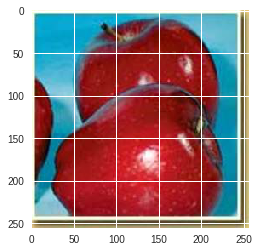

In [167]:
import os

path = '/content/drive/Colab Notebooks/Elice_project/apple2orange/trainA'
ds_X = np.array([])
count = 0
for item in os.listdir(path):
  print("count : {} item : {}".format(count, item))
  count += 1
  if count > 300:
    break
  imgpath = path+'/'+item
  img = Image.open(imgpath)
  img = img.resize((256,256))
  # plt.imshow(img)
  arr = np.array(img)
  img = Image.fromarray(arr, 'RGB')
  plt.imshow(img)
  ds_X = np.append(ds_X, arr)

In [168]:
print(ds_X)

[255. 204.   1. ... 224. 203. 124.]


In [169]:
ds_X = ds_X.reshape(-1,256,256,3)
print(ds_X.shape)

(300, 256, 256, 3)


count : 0 item : n07749192_8038.jpg
count : 1 item : n07749192_8052.jpg
count : 2 item : n07749192_806.jpg
count : 3 item : n07749192_8054.jpg
count : 4 item : n07749192_807.jpg
count : 5 item : n07749192_8105.jpg
count : 6 item : n07749192_812.jpg
count : 7 item : n07749192_815.jpg
count : 8 item : n07749192_8156.jpg
count : 9 item : n07749192_8075.jpg
count : 10 item : n07749192_8129.jpg
count : 11 item : n07749192_819.jpg
count : 12 item : n07749192_8203.jpg
count : 13 item : n07749192_8195.jpg
count : 14 item : n07749192_8237.jpg
count : 15 item : n07749192_8187.jpg
count : 16 item : n07749192_8243.jpg
count : 17 item : n07749192_8234.jpg
count : 18 item : n07749192_8226.jpg
count : 19 item : n07749192_8213.jpg
count : 20 item : n07749192_8235.jpg
count : 21 item : n07749192_8272.jpg
count : 22 item : n07749192_8307.jpg
count : 23 item : n07749192_8277.jpg
count : 24 item : n07749192_8326.jpg
count : 25 item : n07749192_8275.jpg
count : 26 item : n07749192_839.jpg
count : 27 item :

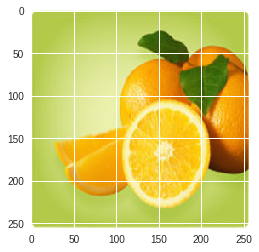

In [170]:
path = '/content/drive/Colab Notebooks/Elice_project/apple2orange/trainB'
ds_Y = np.array([])
count = 0
for item in os.listdir(path):
  print("count : {} item : {}".format(count, item))
  count += 1
  if count > 300:
    break
  imgpath = path+'/'+item
  img = Image.open(imgpath)
  img = img.resize((256,256))
  plt.imshow(img)
  arr = np.array(img)
  ds_Y = np.append(ds_Y, arr)

In [171]:
ds_Y = ds_Y.reshape(-1,256,256,3)
print(ds_Y.shape)

(300, 256, 256, 3)


In [172]:
X_i, Y_i = next(batch_generator_dataset(ds_X, ds_Y))
X_i.shape, Y_i.shape

((1, 256, 256, 3), (1, 256, 256, 3))

## Training

In [0]:
idx = 0
it_i = 0
n_epochs = 10
ckpt_path = './'

3000 G: 1957.2822 D_X: 0.585881 D_Y: 0.581388
3001 G: 3662.3733 D_X: 0.58333284 D_Y: 0.56465524
3002 G: 2573.8535 D_X: 0.55695415 D_Y: 0.5690638
3003 G: 2179.067 D_X: 0.5626478 D_Y: 0.5770763
3004 G: 2940.975 D_X: 0.5343585 D_Y: 0.5738633
3005 G: 3345.2034 D_X: 0.5250006 D_Y: 0.5528635
3006 G: 1161.3267 D_X: 0.50538313 D_Y: 0.55870736
3007 G: 2021.186 D_X: 0.52464 D_Y: 0.56053597
3008 G: 2217.2056 D_X: 0.51628995 D_Y: 0.57329035
3009 G: 2397.0254 D_X: 0.5265605 D_Y: 0.55693173
3010 G: 2175.937 D_X: 0.5153624 D_Y: 0.5619843
3011 G: 2903.4734 D_X: 0.50041854 D_Y: 0.5532488
3012 G: 2630.7976 D_X: 0.50569713 D_Y: 0.5392122
3013 G: 3077.037 D_X: 0.5183353 D_Y: 0.5390634
3014 G: 2607.7551 D_X: 0.49031758 D_Y: 0.53355694
3015 G: 2097.755 D_X: 0.5144256 D_Y: 0.5644305
3016 G: 1950.3225 D_X: 0.5114496 D_Y: 0.5544942
3017 G: 2245.142 D_X: 0.49201128 D_Y: 0.5527306
3018 G: 2532.2114 D_X: 0.52292335 D_Y: 0.54467297
3019 G: 3499.2227 D_X: 0.52178407 D_Y: 0.5563909
3020 G: 2096.1206 D_X: 0.50624263 

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


3300 G: 2439.1602 D_X: 0.4594574 D_Y: 0.48009366
3301 G: 2265.6763 D_X: 0.46407193 D_Y: 0.4745878
3302 G: 1656.9592 D_X: 0.45368543 D_Y: 0.47993493
3303 G: 2432.8408 D_X: 0.46085444 D_Y: 0.47935492
3304 G: 3612.7346 D_X: 0.4519245 D_Y: 0.5060067
3305 G: 1308.828 D_X: 0.4737285 D_Y: 0.48301533
3306 G: 2263.2302 D_X: 0.45255166 D_Y: 0.47211063
3307 G: 2132.2217 D_X: 0.4551557 D_Y: 0.4778156
3308 G: 2949.1333 D_X: 0.45213985 D_Y: 0.4765454
3309 G: 1960.4319 D_X: 0.46038255 D_Y: 0.4756372
3310 G: 2970.501 D_X: 0.46582758 D_Y: 0.50316966
3311 G: 2019.5437 D_X: 0.45010307 D_Y: 0.4714798
3312 G: 2896.7695 D_X: 0.4510203 D_Y: 0.477546
3313 G: 2223.8865 D_X: 0.45057136 D_Y: 0.4741376
3314 G: 3519.5059 D_X: 0.45313954 D_Y: 0.4792708
3315 G: 3382.09 D_X: 0.4559961 D_Y: 0.48062742
3316 G: 2909.955 D_X: 0.45272177 D_Y: 0.49424547
3317 G: 2418.5596 D_X: 0.45359415 D_Y: 0.49386102
3318 G: 1724.7681 D_X: 0.45421663 D_Y: 0.47786492
3319 G: 2731.6514 D_X: 0.45184755 D_Y: 0.4847086
3320 G: 1804.238 D_X: 

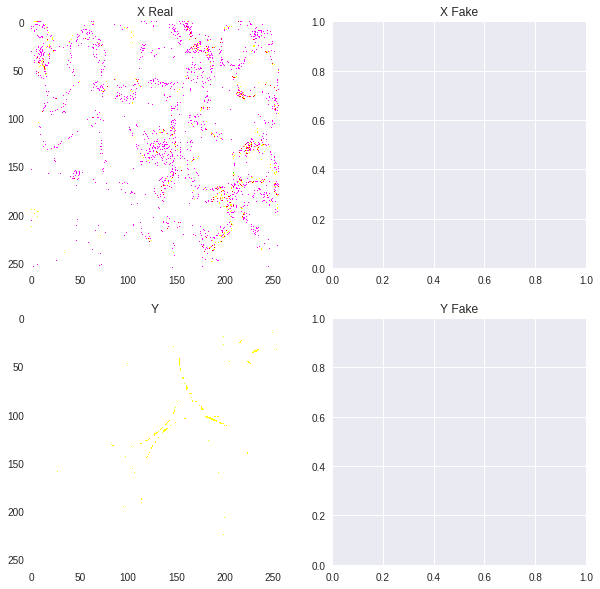

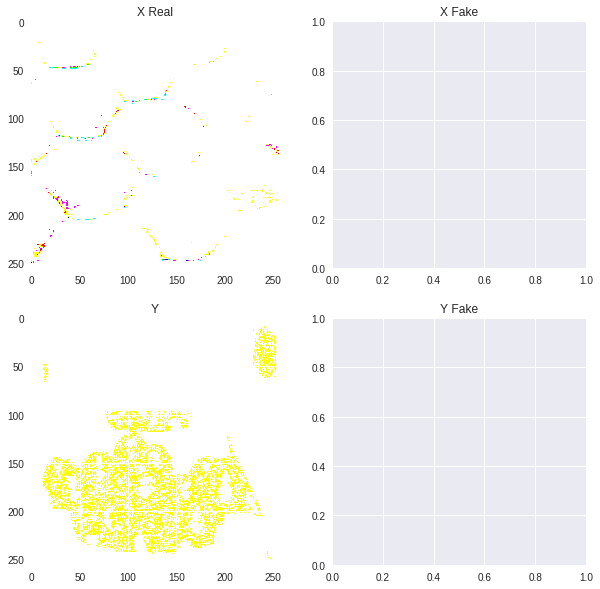

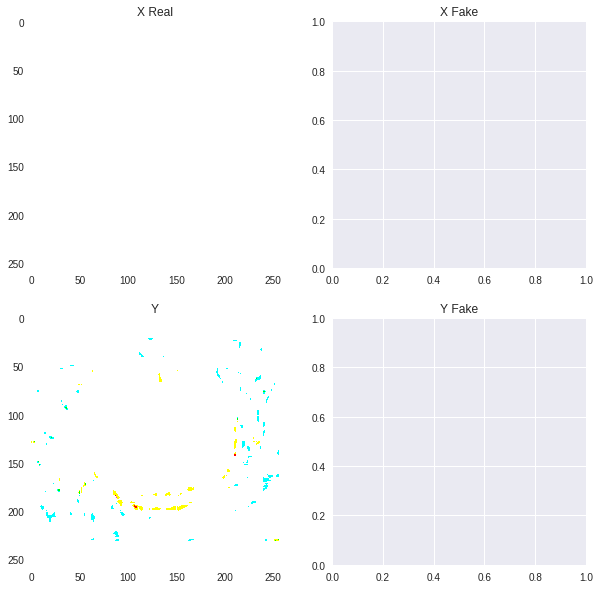

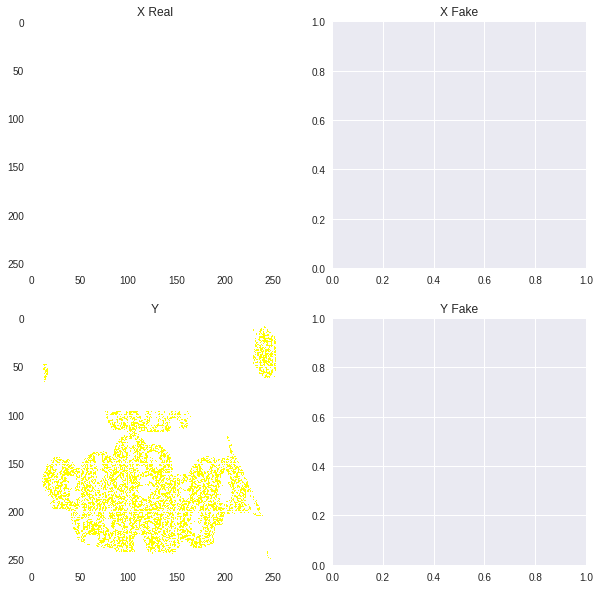

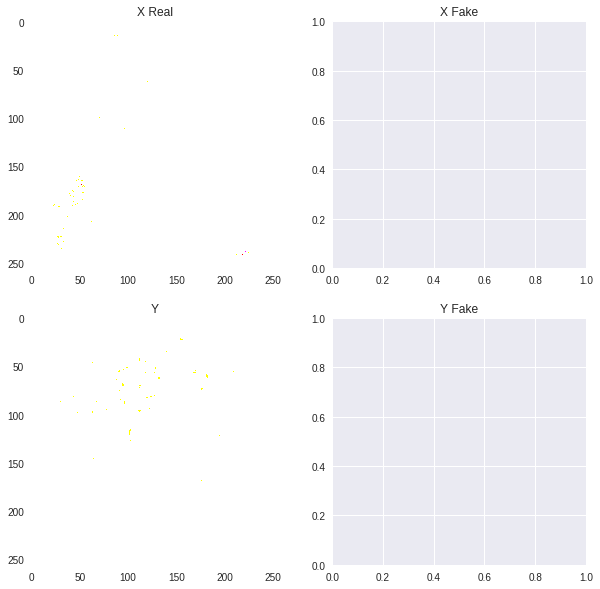

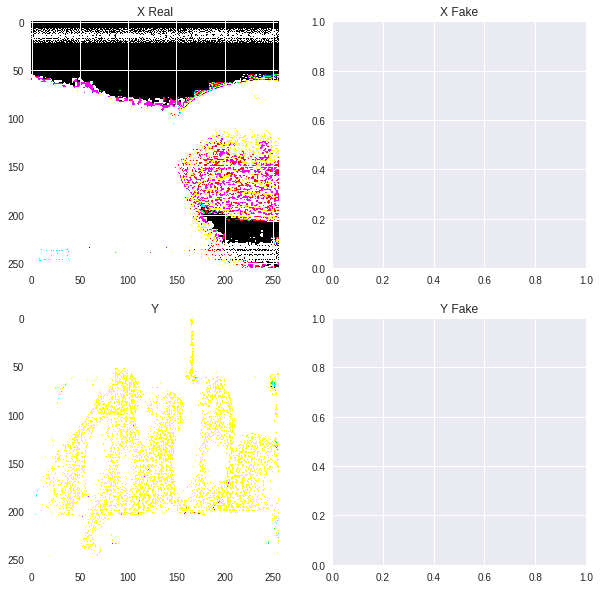

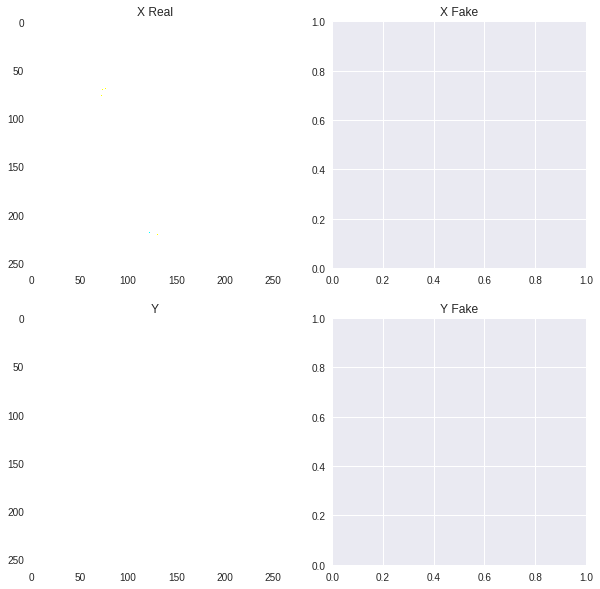

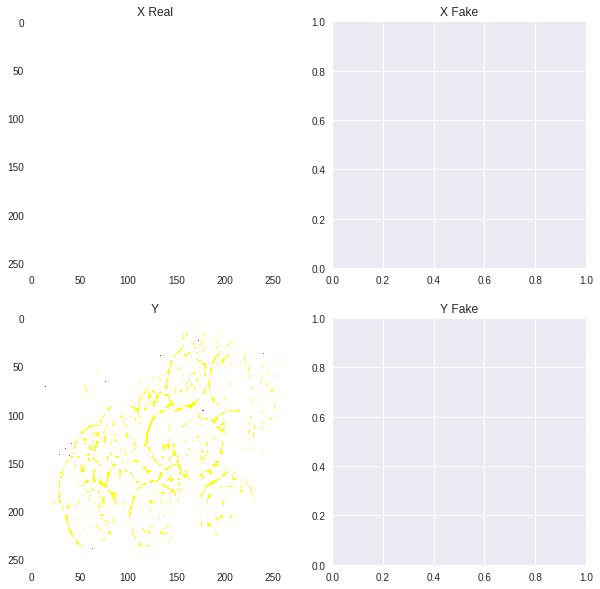

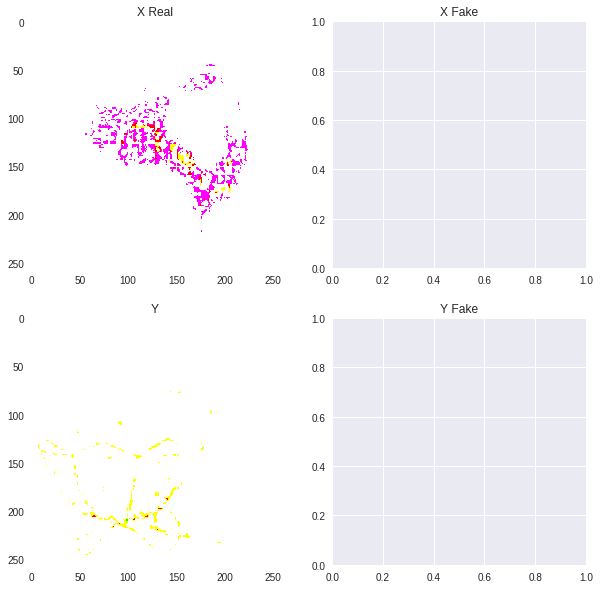

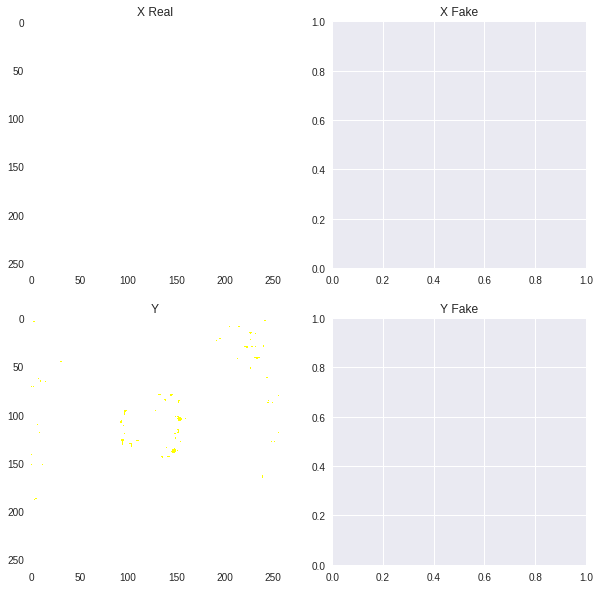

In [175]:
# Train
with tf.Session() as sess:
    # Build an init op for our variables
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    sess.run(init_op)
    
    # We'll also save our model so we can load it up again
    saver = tf.train.Saver()
    writer = tf.summary.FileWriter(ckpt_path)
    
    for epoch_i in range(n_epochs):
        # You'll want to use the approriate batch generator here!
        for X, Y in batch_generator_dataset(ds_X, ds_Y):

            # First generate in both directions
            X_fake, Y_fake = sess.run(
                [net['X_fake'], net['Y_fake']],
                feed_dict={net['X_real']: X,
                           net['Y_real']: Y})

            # Now sample from history
            if it_i < capacity:
                # Not enough samples yet, fill up history buffer
                fake_Xs[idx] = X_fake
                fake_Ys[idx] = Y_fake
                idx = (idx + 1) % capacity
            elif np.random.random() > 0.5:
                # Swap out a random idx from history
                rand_idx = np.random.randint(0, capacity)
                fake_Xs[rand_idx], X_fake = X_fake, fake_Xs[rand_idx]
                fake_Ys[rand_idx], Y_fake = Y_fake, fake_Ys[rand_idx]
            else:
                # Use current generation
                pass

            # Optimize G Networks
            loss_G = sess.run(
                [net['loss_G'], G],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake,
                    net['X_fake_sample']: X_fake
                })[0]

            # Optimize D_Y
            loss_D_Y = sess.run(
                [net['loss_D_Y'], D_Y],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['Y_fake_sample']: Y_fake
                })[0]

            # Optimize D_X
            loss_D_X = sess.run(
                [net['loss_D_X'], D_X],
                feed_dict={
                    net['X_real']: X,
                    net['Y_real']: Y,
                    net['X_fake_sample']: X_fake
                })[0]

            print(it_i, 'G:', loss_G, 'D_X:', loss_D_X, 'D_Y:', loss_D_Y)

            # Update summaries
            if it_i % 100 == 0:
                summary = sess.run(
                    net['summaries'],
                    feed_dict={
                        net['X_real']: X,
                        net['Y_real']: Y,
                        net['X_fake_sample']: X_fake,
                        net['Y_fake_sample']: Y_fake
                    })
                writer.add_summary(summary, it_i)
            it_i += 1

        # Save
        if epoch_i % 50 == 0:
            saver.save(
                sess,
                os.path.join(ckpt_path, 'model.ckpt'),
                global_step=epoch_i)
            
        # Show generative images:        
        fig, axs = plt.subplots(2, 2, figsize=(10, 10))
        
        axs[0][0].set_title('X Real')
        axs[0][0].imshow(np.clip(X[0], 0.0, 1.0))

        axs[0][1].set_title('X Fake')
        # axs[0][1].imshow(np.clip(X_fake[0], 0.0, 1.0))
        img = Image.fromarray(X_fake[0] * 255. // 1.0,"RGB")
        Fake_X = "x" + str(epoch_i) + ".png"
        img = img.resize((256,256))
        img.save(Fake_X)
        # axs[0][1].imshow(img) 
        
        
        axs[1][0].set_title('Y')
        axs[1][0].imshow(np.clip(Y[0], 0.0, 1.0))
        
        axs[1][1].set_title('Y Fake')
        # axs[1][1].imshow(np.clip(Y_fake[0], 0.0, 1.0))
        img = Image.fromarray(Y_fake[0] * 255. // 1.0,"RGB")
        img = img.resize((256,256))
        Fake_Y = "y" + str(epoch_i) + ".png"
        img.save(Fake_Y)
        # axs[1][1].imshow(img)
        fig.show();